In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import os

import string

%matplotlib inline

In [7]:
def get_hour(item):
    return item.hour

def get_day_frame(directory, date, remove_zeros=True, cutoff_area=10000, dropna_thres=4,
                 parse_filename=False, find_cumtime=True,
                 col_names = ['Interval', 'x', 'y', 'Area', 'Hour', 'Minute', 'Second']):
    """
    Returns the day frame for all files in the directory
    date: (month, date, year) tuple, for adding the relevant columns
    parse_filename: set True for files without timestamp, will infer timestamps from filename
    find_cumtime: set False for files that have intervals that are cumulative instead of dt
    """
    files = glob.glob(directory + '/*.csv') 
    
    if files == []:
        return None
    
    frames = []
    for filename in files:
        obs = pd.read_csv(filename, header=None, names=col_names)
        
        # Remove nan columns
        obs.dropna(thresh=dropna_thres)
        
        # Parse filename to get time of the record
        if parse_filename:
            components = string.split(filename, '_')
            timestr = string.join(components[1:], ':')[:-4]
            endtime = pd.to_datetime(timestr)
            
            
            if find_cumtime:
                cum_time = np.cumsum(obs.Interval)
            else:
                cum_time = obs.Interval
            
            cum_time_delta = pd.to_timedelta(cum_time, unit='s')
            starttime = endtime - cum_time_delta[obs.shape[0] - 1]
            obs['Time'] = starttime + cum_time_delta
        
                 
        frames.append(obs)

    # Concatenate readings from all files
    day_frame = pd.concat(frames)
    day_frame['Day'] = date[1]
    day_frame['Month'] = date[0]
    day_frame['Year'] = date[2]
    
    if not parse_filename:
        day_frame['Time'] = pd.to_datetime(day_frame[['Day','Month', 'Year','Hour','Minute','Second']])
    
    # Light hour is from 9am to 7pm
    day_frame['Light'] = (day_frame.Time.apply(get_hour) >= 7) & (day_frame.Time.apply(get_hour) <= 21)
    
    # Remove zeros if specified
    if remove_zeros:
        day_frame = day_frame[(day_frame['x'] != 0) & (day_frame['y'] != 0)]
        
    # Remove entries which exceed a cutoff area
    if cutoff_area != None:
        day_frame = day_frame[day_frame.Area < cutoff_area]
        
    
    
    return day_frame
  

def collect_all_days(parent_dir, days, remove_zeros=True, cutoff_area=10000, dropna_thres=4,
                  parse_filename=False, find_cumtime=True,
                  col_names = ['Interval', 'x', 'y', 'Area', 'Hour', 'Minute', 'Second']):
    '''
    ------------------------
    Inputs:
    parent_dir: string indicating parent directory
    days: list of recording days
    ------------------------
    Output:
    A pd frame for all observations of that animal
    ------------------------    
    '''
    frames = []
    for day in days:
        #datestr = str(day[0]) + '/' + str(day[1]) + '/' + str(day[2])
        #datetime = pd.to_datetime(datestr)
        directory = parent_dir + day.strftime('%m%d') #+ '_proc/'
        print directory
        if os.path.isdir(directory):
            day_frame = get_day_frame(directory, (day.month, day.day, day.year),
                                     remove_zeros, cutoff_area, dropna_thres,
                                     parse_filename, find_cumtime, col_names)
            frames.append(day_frame)
        else:
            print '     Directory does not exist'
    
    return pd.concat(frames)

In [20]:
np.diff?

In [59]:
def get_displacement(day_frame):
    '''
    Get displacement from x and y coords
    '''
    
    dx = np.diff(day_frame['x'])
    dy = np.diff(day_frame['y'])
    displacement = np.sqrt(dx * dx + dy * dy)
    
    # Diff returns n-1 values, so concatenate a 0 behind and make a new column
    return np.concatenate((displacement, [0])) 

def get_zeit(day_frame, start_time_str=None, use_time_field=False):
    '''
    Compute the zeitgeber time, starting from 9am, in unit of hours
    '''
    timeseries = day_frame.Time
    
    if start_time_str == None:
        starttime = timeseries[0]
    else:
        starttime = pd.to_datetime(start_time_str)

    return (timeseries - starttime) / pd.Timedelta(1, unit='h')

def get_crossing(day_frame, xline=160):
    '''
    Compute the time of crossings across the specified xline
    Will return an np array with T being the time of crossing
    '''
    leftright = day_frame.x < 160
    diff = np.diff(leftright)
    
    return np.concatenate((diff, [0])) 

def plot_all_data(frame, axis):
    '''
    Make a plot of all displacement values
    '''
    axis.plot(frame['ZeitTime'], frame['Displacement'], '.', alpha=0.3)
    axis.fill_between(frame.ZeitTime, 0, axis.get_ylim()[1], 
                    where=~frame.Light, color='gray',  alpha=0.3)
    axis.set_xlabel('Zeitbeger time (h)')
    axis.set_ylabel('Displacement (pix)')
    
def ecdf(data):
    return np.sort(data), np.arange(len(data)) / float(len(data))

def aggregate_activity(day_frame, time, unit, axis=None, plot=False,
                      name='Bird', save=False):
    """
    Unit: either 'Hour', 'Minute', or 'Second'
    If plot set to True, also plot the activity
    Returns a data frame which is the total distance travelled in time * unit time specified
    """
    if unit == 'Hour':
        scale = 3600
    elif unit == 'Minute':
        scale = 60
    elif unit == 'Second':
        scale = 1
    else:
        raise ValueError('Invalid time unit')
        
    group_duration = time * scale # Number of seconds to group
    SECS_PER_DAY = 3600 * 24
    
    # ZeitTime is measured in hours, partitioned into groups of
    # specified group_duration
    group = (day_frame['ZeitTime'] / (group_duration/3600.0)).astype('int')
    agg_displacement = day_frame[['Displacement', 'Crosses']].groupby(group)
    
    agg_sum_grouped = agg_displacement.sum().reset_index()
    
    # Create data frame with day information
    agg_sum_grouped['Day'] = (agg_sum_grouped['ZeitTime'] / (SECS_PER_DAY / group_duration)).astype('int')
    agg_sum_grouped['Period'] = agg_sum_grouped['ZeitTime'] % int(SECS_PER_DAY / group_duration)
    
    # Produce a plot if instructed
    if plot:
        for day in agg_sum_grouped.Day.unique():
            activity_day = agg_sum_grouped.Displacement[agg_sum_grouped.Day == day]
            crosses_day = agg_sum_grouped.Crosses[agg_sum_grouped.Day == day]
            time_in_day = agg_sum_grouped.Period[agg_sum_grouped.Day == day] /3
            axis[0].plot(time_in_day, activity_day)
            axis[1].plot(time_in_day, crosses_day)
        axis[0].set_xlabel('Time (hour)')
        axis[0].set_ylabel('Total distance in 20 minutes')
        axis[1].set_xlabel('Time (hour)')
        axis[1].set_ylabel('Crosses in 20 minutes')
    
    return agg_sum_grouped

In [63]:
def process_animal(name, start_day_str, start_time_str=' 7:00AM', ndays=5,  
                   time=20, unit='Minute', save=False, 
                   cutoff_area=None, parse_filename=False, find_cumtime=True,
                  col_names = ['Interval', 'x', 'y', 'Area', 'Hour', 'Minute', 'Second'],
                  xline=160):
    '''
    Perform the analysis procedure for the specified animal
    name: string for name of animal, will read from folder of the same name
    start_day_str: string that represents start day, e.g. '9/25/2016'
    periods: number of days to read
    save: indicates whether the final frame should be saved to a .csv
    '''
    days = pd.date_range(start_day_str, periods=ndays, freq='d')
    frame_all = collect_all_days(name + '/', days, 
                                cutoff_area=cutoff_area, parse_filename=parse_filename,
                                find_cumtime=find_cumtime, col_names=col_names)

    # Sort, then calculate displacement and zeitbeger time
    frame_all = frame_all.sort_values('Time')
    frame_all['Displacement'] = get_displacement(frame_all)
    frame_all['ZeitTime'] = get_zeit(frame_all, start_time_str=start_day_str + start_time_str)
    frame_all['Crosses'] = get_crossing(frame_all, xline=xline)
 
    # Make plots of (1) all displacement points (2) binned activity, 20 minutes
    fig, ax = plt.subplots(1, 3, figsize=(18,10))
    plot_all_data(frame_all, ax[0])

    activity = aggregate_activity(frame_all, time=time, unit=unit, 
                                  plot=True, axis=(ax[1], ax[2]), save=save, name=name)
    
    # Save the frame when instructed
    if save:
        activity['Animal'] = name
        activity['Bin duration - ' + unit ] = time
        activity['Start Time'] = pd.to_datetime(start_day_str + start_time_str)
        save_filename = 'Binned_results/' + name + '_binned_20min_073117.csv'
        if not os.path.isfile(save_filename):
            activity.to_csv(save_filename)
        else:
            raise IOError('File exists, cannot overwrite...')
            
    return (frame_all, activity)

## Functions for trajectory and heat-map plotting

In [5]:
def plot_trajectory(frame, start_time_str, end_time_str, return_fr=False):
    '''
    Given a frame, plot the animal's trajectory during the specified period
    Returns the frame used for plotting
    '''
    start_time = pd.to_datetime(start_time_str)
    end_time = pd.to_datetime(end_time_str)
    frame_interest = frame[(frame.Time > start_time) & (frame.Time < end_time)]
    plt.plot(frame_interest.x, frame_interest.y)
    
    if return_fr:
        return frame_interest
    
def plot_heatmap(frame, start_time_str, end_time_str, return_fr=False):
    '''
    Given a frame, plot the animal's trajectory during the specified period
    Returns the frame used for plotting
    '''
    start_time = pd.to_datetime(start_time_str)
    end_time = pd.to_datetime(end_time_str)
    frame_interest = frame[(frame.Time > start_time) & (frame.Time < end_time)]
    
    heatmap, x_edges, y_edges  = np.histogram2d(frame_interest.x, frame_interest.y, 
                                  weights=frame_interest.Interval, bins=50)
    extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
    
    with sns.axes_style("dark"):
        plt.imshow(heatmap.T, extent=extent, cmap='jet')
        
    if return_fr:
        return heatmap
    

(array([  5.90640100e+06,   1.00000000e+00,   0.00000000e+00,
          4.00000000e+00,   1.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          9.94212000e+05]),
 array([   200.,   5940.,  11680.,  17420.,  23160.,  28900.,  34640.,
         40380.,  46120.,  51860.,  57600.]),
 <a list of 10 Patch objects>)

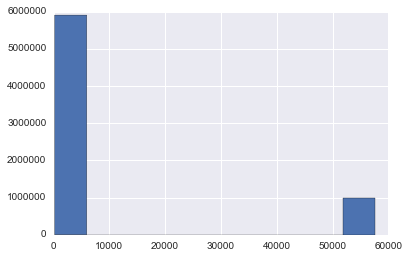

In [12]:
plt.hist(fr_2CW100.y)

In [57]:
activity

,ZeitTime,Displacement,Crosses,Day,Period
0,6,79243.082467,164,0,6
1,7,81572.571842,234,0,7
2,8,31232.365077,56,0,8
3,9,87446.370135,158,0,9
4,10,112361.057323,322,0,10
5,11,100836.084715,271,0,11
6,12,136137.105924,340,0,12
7,13,114308.432688,305,0,13
8,14,62469.096626,166,0,14
9,15,97663.686941,263,0,15


In [ ]:
fr, activity = process_animal('2CW100', '9/25/2016', ndays=5, save=True)

2CW100/0925
2CW100/0926
2CW100/0927


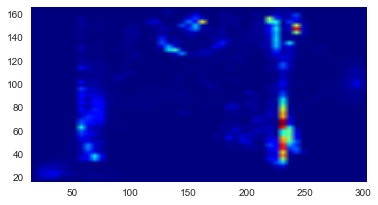

In [102]:
hm = plot_heatmap(fr_2CW100, '9/29/2016 10:00AM', '9/29/2016 4:00PM', return_fr=False)

2CW305/0714_proc/
2CW305/0715_proc/
2CW305/0716_proc/
2CW305/0717_proc/


,Interval,x,y,Hour,Minute,Second,Day,Month,Year,Time,Light,Displacement,ZeitTime
0,0.398700,55.220,43.034,15,34,16.199,14,7,2016,2016-07-14 15:34:16.199,True,3.476248,8.571166
1,0.043062,58.694,42.909,15,34,16.242,14,7,2016,2016-07-14 15:34:16.242,True,5.038731,8.571178
2,0.061657,53.691,42.310,15,34,16.304,14,7,2016,2016-07-14 15:34:16.304,True,0.222009,8.571196
3,0.026670,53.649,42.528,15,34,16.331,14,7,2016,2016-07-14 15:34:16.331,True,0.272738,8.571203
4,0.057288,53.418,42.383,15,34,16.388,14,7,2016,2016-07-14 15:34:16.388,True,0.294864,8.571219
5,0.016808,53.710,42.424,15,34,16.406,14,7,2016,2016-07-14 15:34:16.406,True,0.107355,8.571224
6,0.016363,53.613,42.378,15,34,16.422,14,7,2016,2016-07-14 15:34:16.422,True,0.853493,8.571228
7,0.036031,52.786,42.167,15,34,16.458,14,7,2016,2016-07-14 15:34:16.458,True,5.231329,8.571238
8,0.036078,57.934,43.097,15,34,16.494,14,7,2016,2016-07-14 15:34:16.494,True,4.057117,8.571248
9,0.025636,53.928,42.455,15,34,16.520,14,7,2016,2016-07-14 15:34:16.520,True,0.210737,8.571256


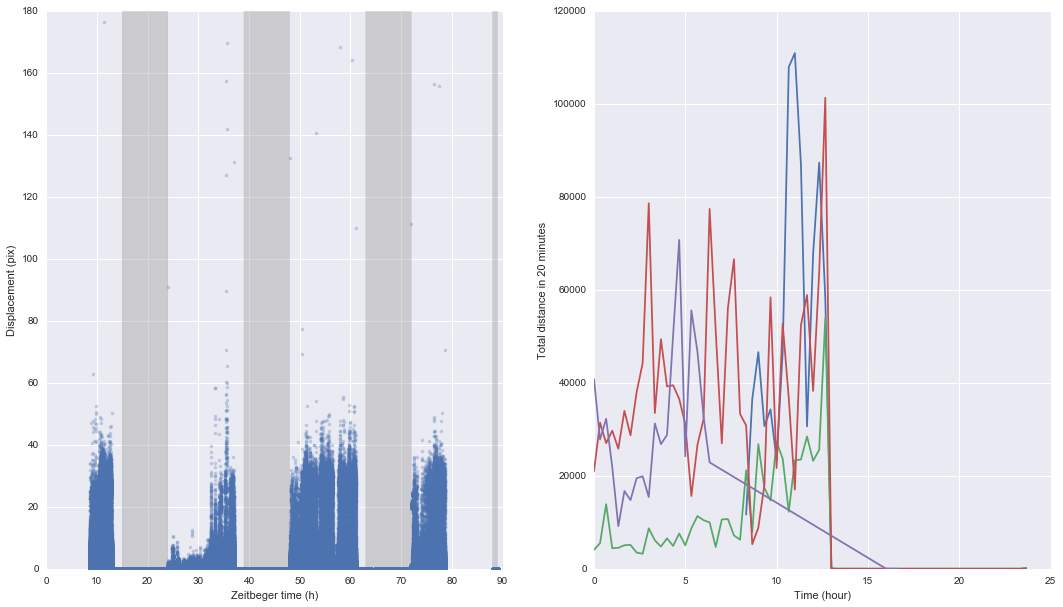

In [14]:
process_animal('2CW305', '7/14/2016', ndays=4, save=True)

In [16]:
process_animal('2CW318', '6/28/2016', ndays=4, save=True, parse_filename=True)

2CW318/0628_proc/


ValueError: Unknown string format

In [ ]:
process_animal('LB21', '7/1/2016', ndays=5, save=True, col_names = ['Interval', 'x', 'y', 'Hour', 'Minute', 'Second'])

2CW312/0709_proc/
2CW312/0710_proc/
2CW312/0711_proc/
2CW312/0712_proc/
2CW312/0713_proc/
2CW312/0714_proc/


ValueError: Cannot convert NA to integer

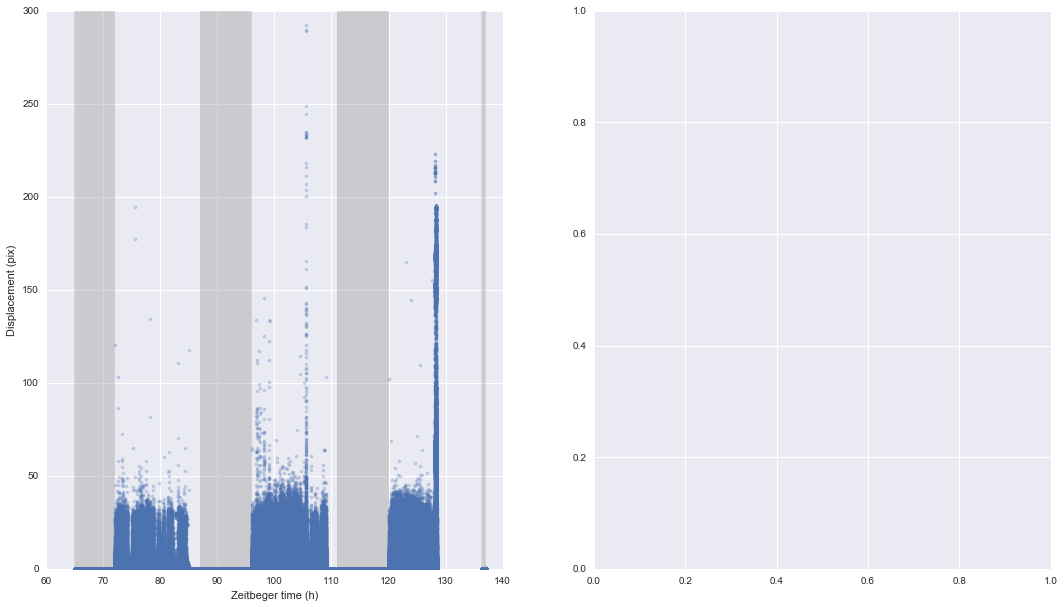

In [17]:
process_animal('2CW312', '7/9/2016', ndays=6, save=True, col_names = ['Interval', 'x', 'y', 'Hour', 'Minute', 'Second'])

LB15/0711_proc/
LB15/0712_proc/
LB15/0713_proc/
LB15/0714_proc/


ValueError: Cannot convert NA to integer

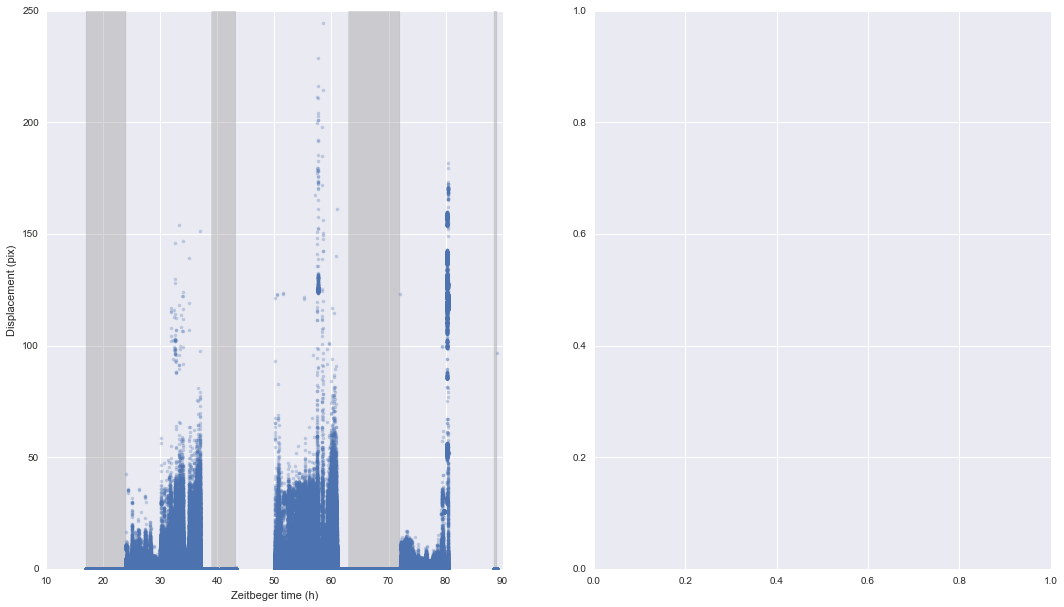

In [18]:
act = process_animal('LB15', '7/11/2016', ndays=4, save=True, col_names = ['Interval', 'x', 'y', 'Hour', 'Minute', 'Second'])

2CW306/0719_proc/
2CW306/0720_proc/
2CW306/0721_proc/
2CW306/0722_proc/


,Interval,x,y,Hour,Minute,Second,Day,Month,Year,Time,Light,Displacement,ZeitTime
0,0.948050,160.000,90.000,17,53,54.213,19,7,2016,2016-07-19 17:53:54.213,True,0.000000,10.898392
1,0.036900,160.000,90.000,17,53,54.250,19,7,2016,2016-07-19 17:53:54.250,True,123.567312,10.898403
2,0.078429,58.678,19.270,17,53,54.329,19,7,2016,2016-07-19 17:53:54.329,True,0.314531,10.898425
3,0.027516,58.991,19.239,17,53,54.356,19,7,2016,2016-07-19 17:53:54.356,True,0.000000,10.898432
4,0.053783,58.991,19.239,17,53,54.410,19,7,2016,2016-07-19 17:53:54.410,True,0.076922,10.898447
5,0.025104,59.025,19.308,17,53,54.436,19,7,2016,2016-07-19 17:53:54.436,True,1.348401,10.898454
6,0.016389,57.695,19.086,17,53,54.452,19,7,2016,2016-07-19 17:53:54.452,True,0.000000,10.898459
7,0.035902,57.695,19.086,17,53,54.488,19,7,2016,2016-07-19 17:53:54.488,True,0.000000,10.898469
8,0.025511,57.695,19.086,17,53,54.514,19,7,2016,2016-07-19 17:53:54.514,True,0.000000,10.898476
9,0.050786,57.695,19.086,17,53,54.565,19,7,2016,2016-07-19 17:53:54.565,True,0.000000,10.898490


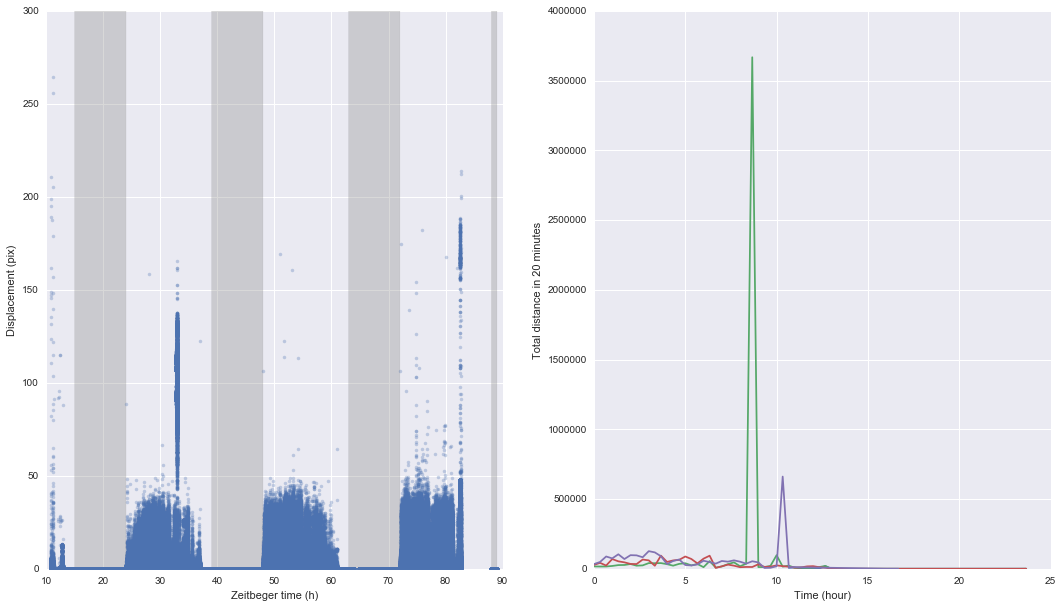

In [19]:
process_animal('2CW306', '7/19/2016', ndays=4, save=True, col_names = ['Interval', 'x', 'y', 'Hour', 'Minute', 'Second'])

2CW308/0714_proc/
2CW308/0715_proc/
2CW308/0716_proc/
2CW308/0717_proc/


,Interval,x,y,Hour,Minute,Second,Day,Month,Year,Time,Light,Displacement,ZeitTime
0,0.524720,77.425,47.168,15,33,45.800,14,7,2016,2016-07-14 15:33:45.800,True,0.379680,8.562722
1,0.046491,77.659,47.467,15,33,45.847,14,7,2016,2016-07-14 15:33:45.847,True,0.369259,8.562735
2,0.067136,77.943,47.703,15,33,45.914,14,7,2016,2016-07-14 15:33:45.914,True,0.219401,8.562754
3,0.031771,77.767,47.572,15,33,45.946,14,7,2016,2016-07-14 15:33:45.946,True,0.160431,8.562763
4,0.060023,77.870,47.695,15,33,46.007,14,7,2016,2016-07-14 15:33:46.007,True,0.348622,8.562780
5,0.019032,77.621,47.451,15,33,46.026,14,7,2016,2016-07-14 15:33:46.026,True,0.428165,8.562785
6,0.017838,77.936,47.741,15,33,46.044,14,7,2016,2016-07-14 15:33:46.044,True,0.348210,8.562790
7,0.027963,77.725,47.464,15,33,46.072,14,7,2016,2016-07-14 15:33:46.072,True,0.125642,8.562798
8,0.037655,77.794,47.569,15,33,46.110,14,7,2016,2016-07-14 15:33:46.110,True,0.299348,8.562808
9,0.027523,77.591,47.349,15,33,46.137,14,7,2016,2016-07-14 15:33:46.137,True,0.038949,8.562816


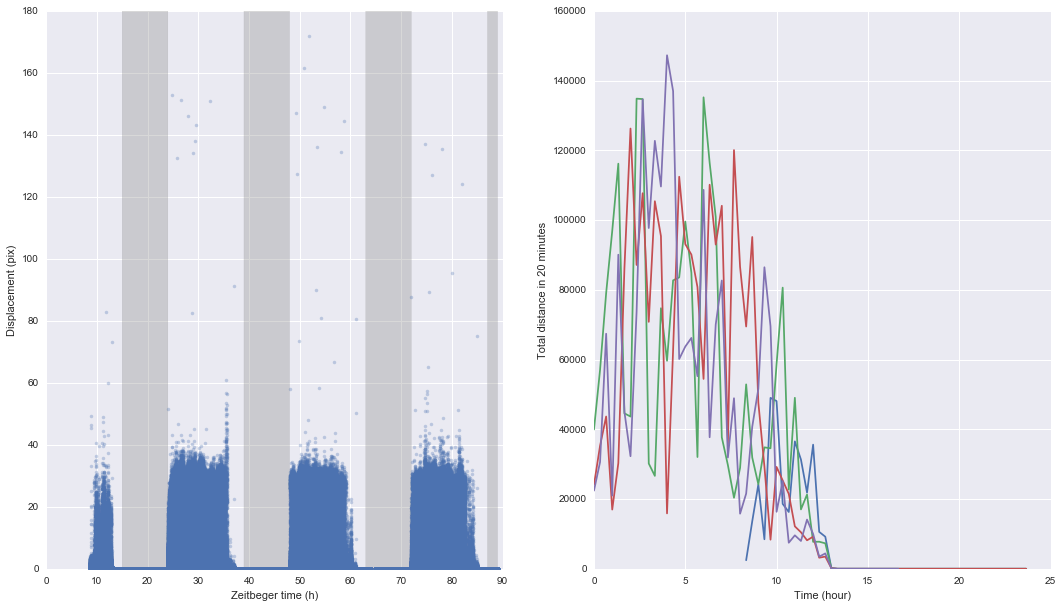

In [20]:
process_animal('2CW308', '7/14/2016', ndays=4, save=True, col_names = ['Interval', 'x', 'y', 'Hour', 'Minute', 'Second'])

LB06/0718_proc/
LB06/0719_proc/
LB06/0720_proc/


,Interval,x,y,Hour,Minute,Second,Day,Month,Year,Time,Light,Displacement,ZeitTime
14741,0.14236,160.5,90.5,0,0,0.078,18,7,2016,2016-07-18 00:00:00.078,False,0.0,-6.999978
14742,0.12768,160.5,90.5,0,0,0.205,18,7,2016,2016-07-18 00:00:00.205,False,0.0,-6.999943
14743,0.11630,160.5,90.5,0,0,0.322,18,7,2016,2016-07-18 00:00:00.322,False,0.0,-6.999911
14744,0.15838,160.5,90.5,0,0,0.480,18,7,2016,2016-07-18 00:00:00.480,False,0.0,-6.999867
14745,0.12696,160.5,90.5,0,0,0.607,18,7,2016,2016-07-18 00:00:00.607,False,0.0,-6.999831
14746,0.12573,160.5,90.5,0,0,0.733,18,7,2016,2016-07-18 00:00:00.733,False,0.0,-6.999796
14747,0.13996,160.5,90.5,0,0,0.873,18,7,2016,2016-07-18 00:00:00.873,False,0.0,-6.999758
14748,0.13480,160.5,90.5,0,0,1.008,18,7,2016,2016-07-18 00:00:01.008,False,0.0,-6.999720
14749,0.11704,160.5,90.5,0,0,1.125,18,7,2016,2016-07-18 00:00:01.125,False,0.0,-6.999688
14750,0.15108,160.5,90.5,0,0,1.276,18,7,2016,2016-07-18 00:00:01.276,False,0.0,-6.999646


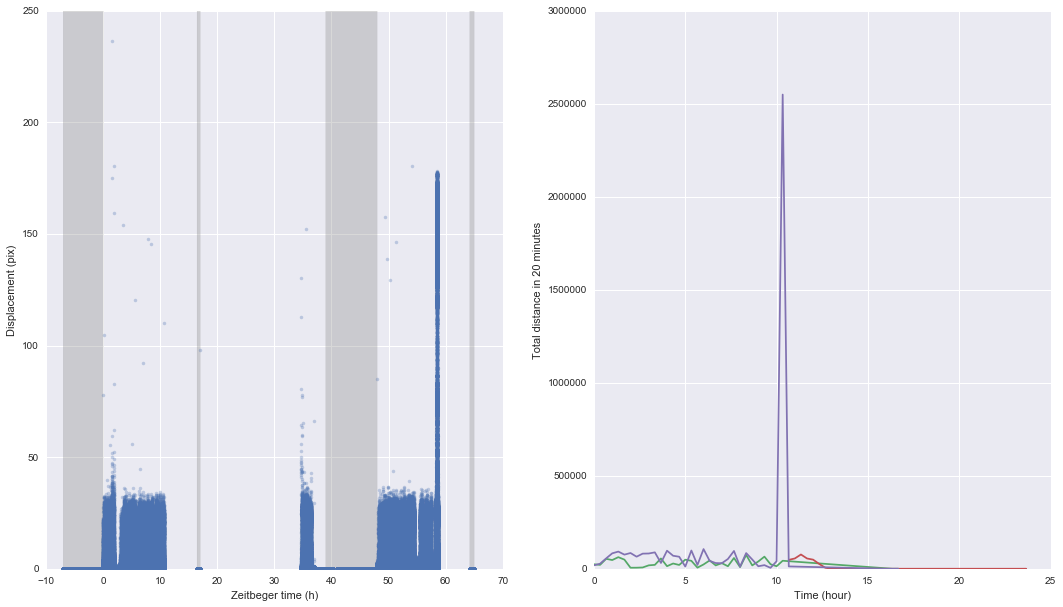

In [21]:
process_animal('LB06', '7/18/2016', ndays=3, save=True, col_names = ['Interval', 'x', 'y', 'Hour', 'Minute', 'Second'])

Or130/0722_proc/
Or130/0723_proc/
Or130/0724_proc/
Or130/0725_proc/
Or130/0726_proc/
Or130/0727_proc/
Or130/0728_proc/


,Interval,x,y,Hour,Minute,Second,Day,Month,Year,Time,Light,Displacement,ZeitTime
0,0.711340,231.47,113.45,17,44,34.608,22,7,2016,2016-07-22 17:44:34.608,True,0.022361,10.742947
1,0.044398,231.45,113.44,17,44,34.652,22,7,2016,2016-07-22 17:44:34.652,True,0.165529,10.742959
2,0.132700,231.30,113.51,17,44,34.785,22,7,2016,2016-07-22 17:44:34.785,True,0.044721,10.742996
3,0.024368,231.26,113.53,17,44,34.810,22,7,2016,2016-07-22 17:44:34.810,True,0.254951,10.743003
4,0.085044,231.51,113.48,17,44,34.895,22,7,2016,2016-07-22 17:44:34.895,True,0.272947,10.743026
5,0.017074,231.78,113.44,17,44,34.913,22,7,2016,2016-07-22 17:44:34.913,True,0.063246,10.743031
6,0.026442,231.80,113.50,17,44,34.940,22,7,2016,2016-07-22 17:44:34.940,True,0.120416,10.743039
7,0.025928,231.71,113.42,17,44,34.965,22,7,2016,2016-07-22 17:44:34.965,True,0.098489,10.743046
8,0.035233,231.80,113.46,17,44,35.001,22,7,2016,2016-07-22 17:44:35.001,True,0.256320,10.743056
9,0.026372,231.56,113.55,17,44,35.027,22,7,2016,2016-07-22 17:44:35.027,True,0.123693,10.743063


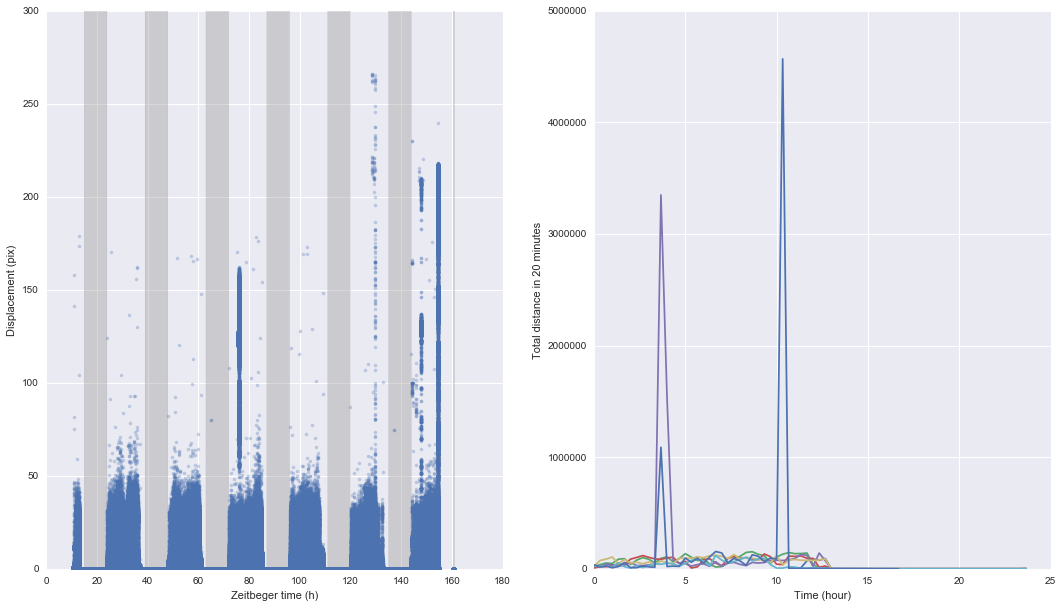

In [22]:
process_animal('Or130', '7/22/2016', ndays=7, save=True, col_names = ['Interval', 'x', 'y', 'Hour', 'Minute', 'Second'])

Or114/0726_proc/
Or114/0727_proc/
Or114/0728_proc/
Or114/0729_proc/
Or114/0730_proc/
Or114/0731_proc/
     Directory does not exist
Or114/0801_proc/
Or114/0802_proc/
Or114/0803_proc/


,Interval,x,y,Hour,Minute,Second,Day,Month,Year,Time,Light,Displacement,ZeitTime
17438,0.12467,160.5,90.5,0,0,0.003,26,7,2016,2016-07-26 00:00:00.003,False,0.0,-6.999999
17439,0.13351,160.5,90.5,0,0,0.137,26,7,2016,2016-07-26 00:00:00.137,False,0.0,-6.999962
17440,0.14209,160.5,90.5,0,0,0.279,26,7,2016,2016-07-26 00:00:00.279,False,0.0,-6.999923
17441,0.12982,160.5,90.5,0,0,0.409,26,7,2016,2016-07-26 00:00:00.409,False,0.0,-6.999886
17442,0.11206,160.5,90.5,0,0,0.521,26,7,2016,2016-07-26 00:00:00.521,False,0.0,-6.999855
17443,0.15132,160.5,90.5,0,0,0.672,26,7,2016,2016-07-26 00:00:00.672,False,0.0,-6.999813
17444,0.13333,160.5,90.5,0,0,0.807,26,7,2016,2016-07-26 00:00:00.807,False,0.0,-6.999776
17445,0.11360,160.5,90.5,0,0,0.920,26,7,2016,2016-07-26 00:00:00.920,False,0.0,-6.999744
17446,0.15946,160.5,90.5,0,0,1.080,26,7,2016,2016-07-26 00:00:01.080,False,0.0,-6.999700
17447,0.11245,160.5,90.5,0,0,1.192,26,7,2016,2016-07-26 00:00:01.192,False,0.0,-6.999669


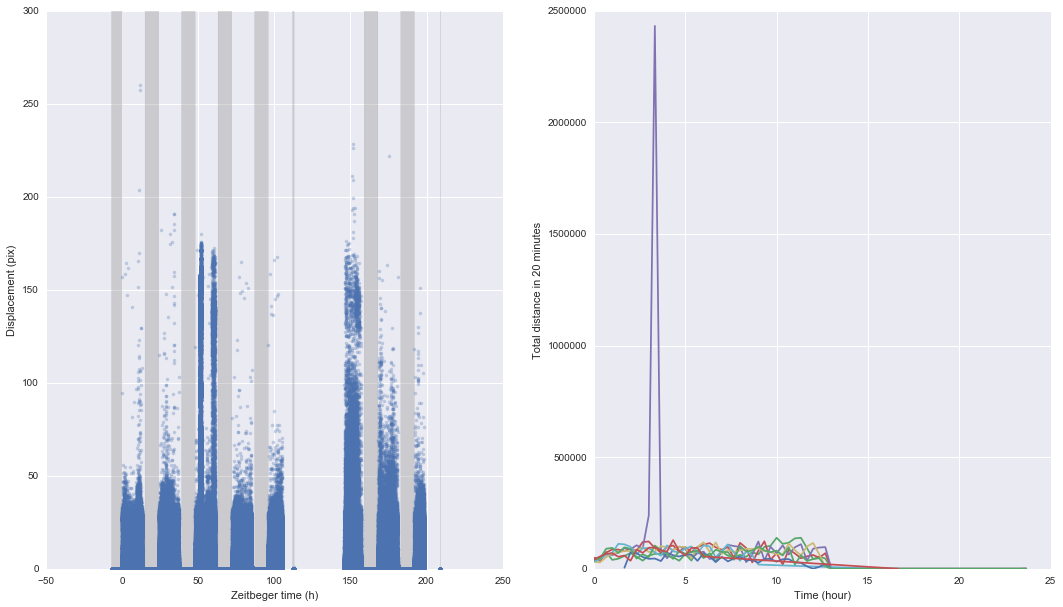

In [23]:
process_animal('Or114', '7/26/2016', ndays=9, save=True, col_names = ['Interval', 'x', 'y', 'Hour', 'Minute', 'Second'])

2CW317/0720_proc/
2CW317/0721_proc/
2CW317/0722_proc/
2CW317/0723_proc/
2CW317/0724_proc/
2CW317/0725_proc/


,Interval,x,y,Hour,Minute,Second,Day,Month,Year,Time,Light,Displacement,ZeitTime
15520,0.00000,47.927,96.126,0,0,0.000,20,7,2016,2016-07-20 00:00:00.000,False,0.0,-7.000000
18368,0.00000,47.927,96.126,0,0,0.000,20,7,2016,2016-07-20 00:00:00.000,False,0.0,-7.000000
18367,0.00000,47.927,96.126,0,0,0.000,20,7,2016,2016-07-20 00:00:00.000,False,0.0,-7.000000
18366,0.00000,47.927,96.126,0,0,0.000,20,7,2016,2016-07-20 00:00:00.000,False,0.0,-7.000000
18365,0.00000,47.927,96.126,0,0,0.000,20,7,2016,2016-07-20 00:00:00.000,False,0.0,-7.000000
18364,0.00000,47.927,96.126,0,0,0.000,20,7,2016,2016-07-20 00:00:00.000,False,0.0,-7.000000
18363,0.00000,47.927,96.126,0,0,0.000,20,7,2016,2016-07-20 00:00:00.000,False,0.0,-7.000000
18362,0.00000,47.927,96.126,0,0,0.000,20,7,2016,2016-07-20 00:00:00.000,False,0.0,-7.000000
18361,0.00000,47.927,96.126,0,0,0.000,20,7,2016,2016-07-20 00:00:00.000,False,0.0,-7.000000
18360,0.00000,47.927,96.126,0,0,0.000,20,7,2016,2016-07-20 00:00:00.000,False,0.0,-7.000000


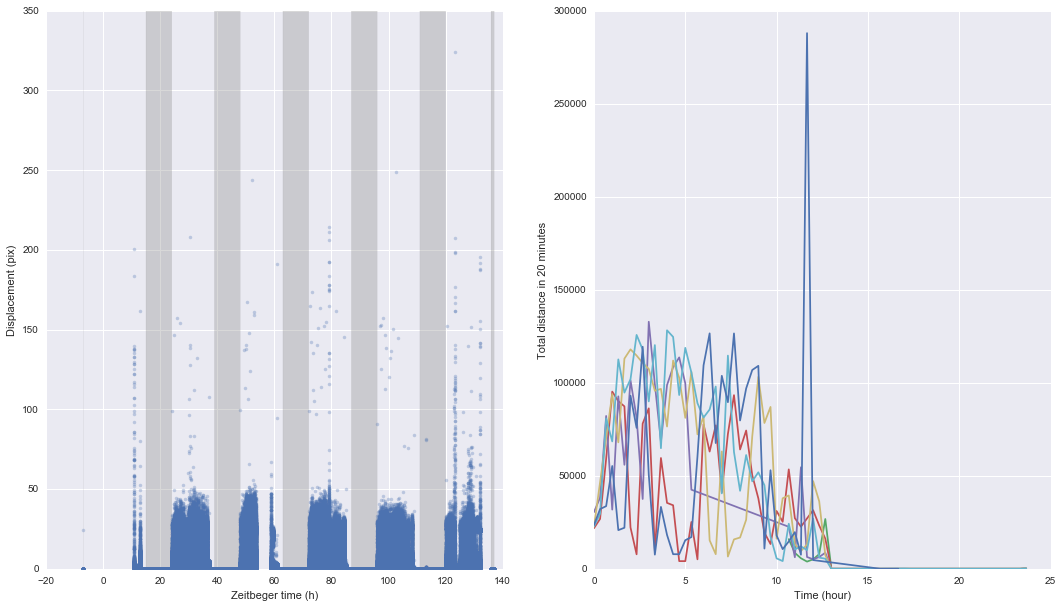

In [24]:
process_animal('2CW317', '7/20/2016', ndays=6, save=True, col_names = ['Interval', 'x', 'y', 'Hour', 'Minute', 'Second'])

Z1Pi229/0803_proc/
Z1Pi229/0804_proc/
Z1Pi229/0805_proc/
Z1Pi229/0806_proc/
Z1Pi229/0807_proc/
Z1Pi229/0808_proc/
Z1Pi229/0809_proc/
Z1Pi229/0810_proc/
Z1Pi229/0811_proc/
Z1Pi229/0812_proc/
Z1Pi229/0813_proc/
Z1Pi229/0814_proc/
Z1Pi229/0815_proc/
Z1Pi229/0816_proc/
Z1Pi229/0817_proc/


,Interval,x,y,Hour,Minute,Second,Day,Month,Year,Time,Light,Displacement,ZeitTime
0,0.247120,68.003,63.625,18,45,46.028,3,8,2016,2016-08-03 18:45:46.028,True,1.578419,11.762786
1,0.149500,66.512,64.143,18,45,46.178,3,8,2016,2016-08-03 18:45:46.178,True,1.971087,11.762827
2,0.131210,64.695,64.907,18,45,46.310,3,8,2016,2016-08-03 18:45:46.310,True,3.048875,11.762864
3,0.063336,67.294,63.313,18,45,46.373,3,8,2016,2016-08-03 18:45:46.373,True,1.088482,11.762881
4,0.090728,67.207,64.398,18,45,46.464,3,8,2016,2016-08-03 18:45:46.464,True,0.848232,11.762907
5,0.055137,66.524,63.895,18,45,46.520,3,8,2016,2016-08-03 18:45:46.520,True,0.777325,11.762922
6,0.046537,67.271,64.110,18,45,46.566,3,8,2016,2016-08-03 18:45:46.566,True,0.194240,11.762935
7,0.038659,67.091,64.037,18,45,46.605,3,8,2016,2016-08-03 18:45:46.605,True,0.451807,11.762946
8,0.045331,67.542,64.010,18,45,46.650,3,8,2016,2016-08-03 18:45:46.650,True,4.181274,11.762958
9,0.046319,63.585,65.361,18,45,46.697,3,8,2016,2016-08-03 18:45:46.697,True,2.884498,11.762971


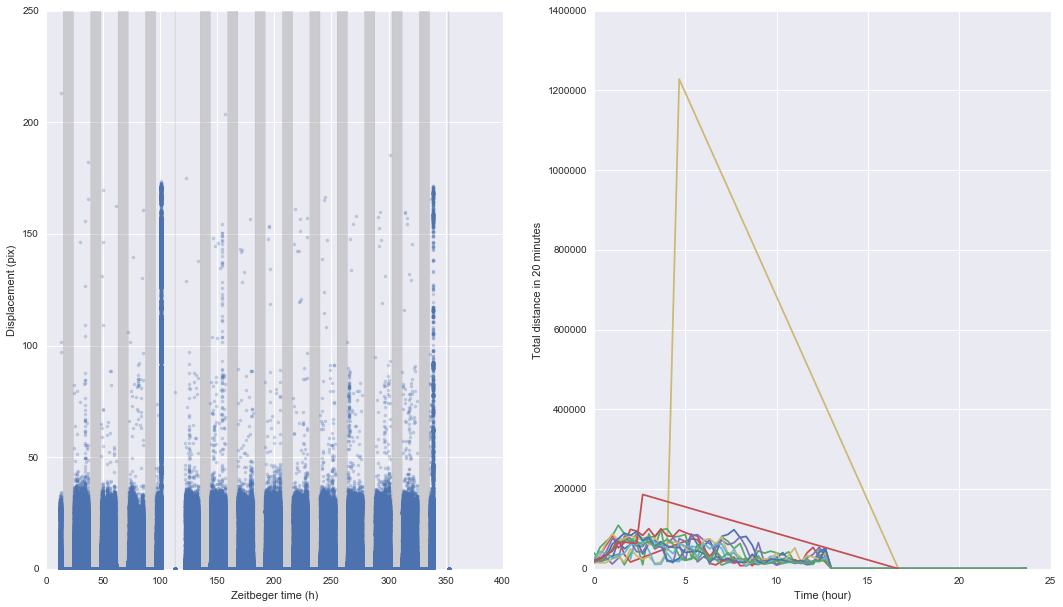

In [25]:
process_animal('Z1Pi229', '8/3/2016', ndays=15, save=True, col_names = ['Interval', 'x', 'y', 'Hour', 'Minute', 'Second'])

Z1Pi230/0803_proc/
Z1Pi230/0804_proc/
Z1Pi230/0805_proc/
Z1Pi230/0806_proc/
     Directory does not exist
Z1Pi230/0807_proc/
     Directory does not exist
Z1Pi230/0808_proc/
Z1Pi230/0809_proc/
Z1Pi230/0810_proc/
Z1Pi230/0811_proc/
Z1Pi230/0812_proc/
Z1Pi230/0813_proc/
Z1Pi230/0814_proc/
Z1Pi230/0815_proc/


,Interval,x,y,Hour,Minute,Second,Day,Month,Year,Time,Light,Displacement,ZeitTime
0,0.394550,94.572,21.795,18,45,59.868,3,8,2016,2016-08-03 18:45:59.868,True,0.194654,11.766630
1,0.341060,94.479,21.624,18,46,0.209,3,8,2016,2016-08-03 18:46:00.209,True,0.281002,11.766725
2,0.250620,94.480,21.905,18,46,0.460,3,8,2016,2016-08-03 18:46:00.460,True,0.309726,11.766794
3,0.097407,94.521,22.212,18,46,0.558,3,8,2016,2016-08-03 18:46:00.558,True,0.364314,11.766822
4,0.092493,94.562,21.850,18,46,0.650,3,8,2016,2016-08-03 18:46:00.650,True,0.786324,11.766847
5,0.036898,93.786,21.977,18,46,0.689,3,8,2016,2016-08-03 18:46:00.689,True,0.858446,11.766858
6,0.056840,94.638,22.082,18,46,0.745,3,8,2016,2016-08-03 18:46:00.745,True,0.813458,11.766874
7,0.030487,93.833,21.965,18,46,0.776,3,8,2016,2016-08-03 18:46:00.776,True,0.483680,11.766882
8,0.058216,94.172,21.620,18,46,0.834,3,8,2016,2016-08-03 18:46:00.834,True,0.761231,11.766898
9,0.030324,94.608,22.244,18,46,0.865,3,8,2016,2016-08-03 18:46:00.865,True,0.395345,11.766907


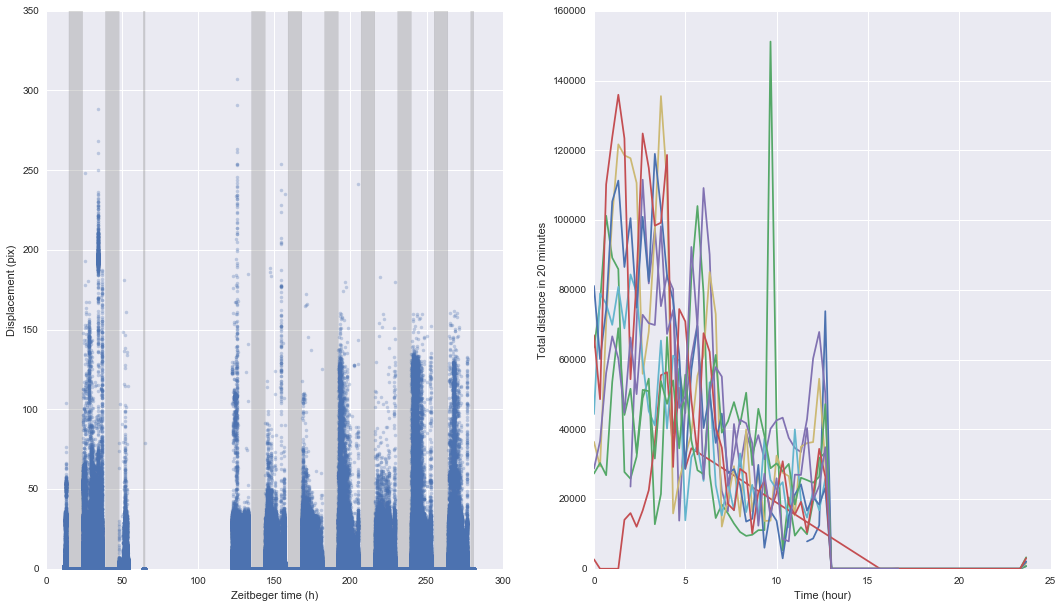

In [26]:
process_animal('Z1Pi230', '8/3/2016', ndays=13, save=True, col_names = ['Interval', 'x', 'y', 'Hour', 'Minute', 'Second'])

LB2/0919_proc/
LB2/0920_proc/
LB2/0921_proc/
LB2/0922_proc/
LB2/0923_proc/
LB2/0924_proc/


,Interval,x,y,Hour,Minute,Second,Day,Month,Year,Time,Light,Displacement,ZeitTime
0,0.050634,161.01,168.33,9,56,52.647,19,9,2016,2016-09-19 09:56:52.647,True,0.121655,2.947957
1,0.136080,160.89,168.31,9,56,52.784,19,9,2016,2016-09-19 09:56:52.784,True,0.060828,2.947996
2,0.123280,160.95,168.32,9,56,52.907,19,9,2016,2016-09-19 09:56:52.907,True,0.120000,2.948030
3,0.058058,160.83,168.32,9,56,52.965,19,9,2016,2016-09-19 09:56:52.965,True,0.180278,2.948046
4,0.058244,161.01,168.31,9,56,53.023,19,9,2016,2016-09-19 09:56:53.023,True,0.036056,2.948062
5,0.060073,161.04,168.33,9,56,53.083,19,9,2016,2016-09-19 09:56:53.083,True,0.220000,2.948079
6,0.061628,160.82,168.33,9,56,53.145,19,9,2016,2016-09-19 09:56:53.145,True,0.141421,2.948096
7,0.062850,160.96,168.31,9,56,53.208,19,9,2016,2016-09-19 09:56:53.208,True,0.050990,2.948113
8,0.061115,161.01,168.30,9,56,53.269,19,9,2016,2016-09-19 09:56:53.269,True,0.020000,2.948130
9,0.031081,160.99,168.30,9,56,53.300,19,9,2016,2016-09-19 09:56:53.300,True,0.085440,2.948139


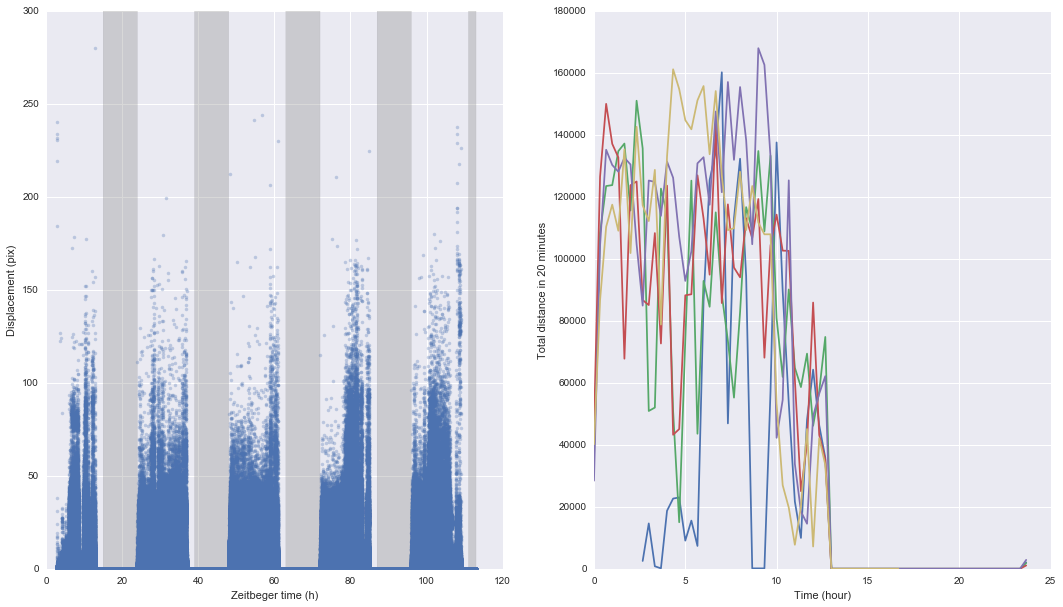

In [27]:
process_animal('LB2', '9/19/2016', ndays=6, save=True, col_names = ['Interval', 'x', 'y', 'Hour', 'Minute', 'Second'])

LB11/0822_proc/
LB11/0823_proc/
LB11/0824_proc/
LB11/0825_proc/
LB11/0826_proc/
LB11/0827_proc/
LB11/0828_proc/
LB11/0829_proc/
LB11/0830_proc/


,Interval,x,y,Hour,Minute,Second,Day,Month,Year,Time,Light,Displacement,ZeitTime
0,0.735680,316.91,120.77,17,6,36.143,22,8,2016,2016-08-22 17:06:36.143,True,0.600333,10.110040
1,0.043265,316.93,120.17,17,6,36.186,22,8,2016,2016-08-22 17:06:36.186,True,0.231948,10.110052
2,0.063884,316.96,120.40,17,6,36.251,22,8,2016,2016-08-22 17:06:36.251,True,0.116619,10.110070
3,0.030747,316.90,120.30,17,6,36.282,22,8,2016,2016-08-22 17:06:36.282,True,0.167631,10.110078
4,0.048842,316.95,120.14,17,6,36.331,22,8,2016,2016-08-22 17:06:36.331,True,0.123693,10.110092
5,0.020521,316.98,120.26,17,6,36.352,22,8,2016,2016-08-22 17:06:36.352,True,0.764199,10.110098
6,0.016625,316.90,121.02,17,6,36.368,22,8,2016,2016-08-22 17:06:36.368,True,0.335410,10.110102
7,0.026237,316.96,120.69,17,6,36.394,22,8,2016,2016-08-22 17:06:36.394,True,0.164924,10.110109
8,0.068579,316.92,120.85,17,6,36.463,22,8,2016,2016-08-22 17:06:36.463,True,0.462709,10.110129
9,0.015049,316.97,120.39,17,6,36.478,22,8,2016,2016-08-22 17:06:36.478,True,0.222036,10.110133


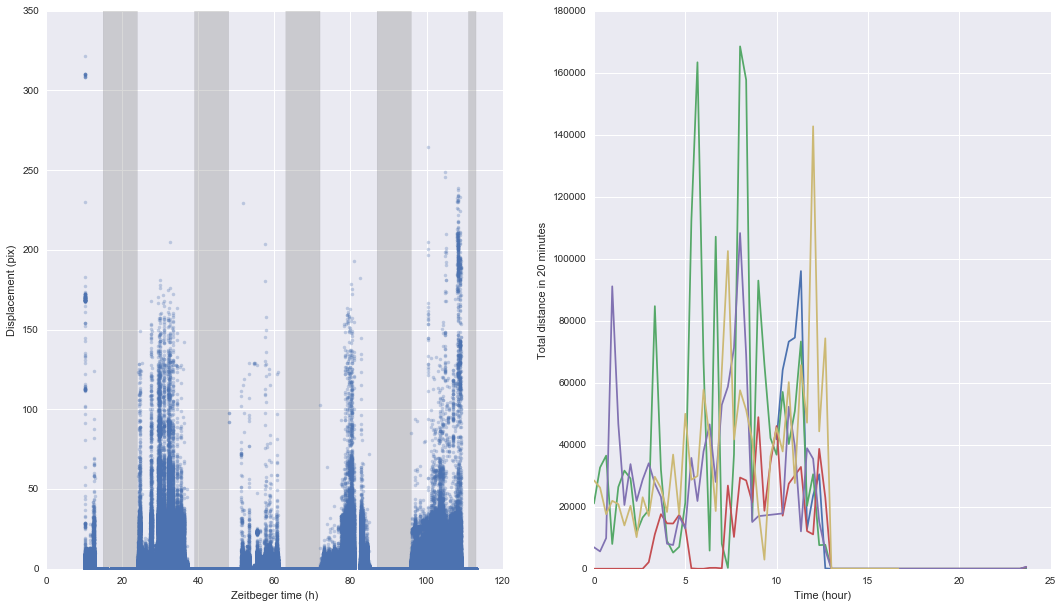

In [28]:
process_animal('LB11', '8/22/2016', ndays=9, save=True, col_names = ['Interval', 'x', 'y', 'Hour', 'Minute', 'Second'])

Or128/0822_proc/
Or128/0823_proc/
Or128/0824_proc/
Or128/0825_proc/
Or128/0826_proc/
Or128/0827_proc/
Or128/0828_proc/
Or128/0829_proc/
Or128/0830_proc/


,Interval,x,y,Hour,Minute,Second,Day,Month,Year,Time,Light,Displacement,ZeitTime
0,0.715880,160.0,90.0,17,13,26.769,22,8,2016,2016-08-22 17:13:26.769,True,0.0,10.224103
1,0.612880,160.0,90.0,17,13,27.382,22,8,2016,2016-08-22 17:13:27.382,True,0.0,10.224273
2,0.126020,160.0,90.0,17,13,27.508,22,8,2016,2016-08-22 17:13:27.508,True,0.0,10.224308
3,0.059380,160.0,90.0,17,13,27.576,22,8,2016,2016-08-22 17:13:27.576,True,0.0,10.224327
4,0.081671,160.0,90.0,17,13,27.658,22,8,2016,2016-08-22 17:13:27.658,True,0.0,10.224349
5,0.079098,160.0,90.0,17,13,27.737,22,8,2016,2016-08-22 17:13:27.737,True,0.0,10.224371
6,0.037805,160.0,90.0,17,13,27.775,22,8,2016,2016-08-22 17:13:27.775,True,0.0,10.224382
7,0.042785,160.0,90.0,17,13,27.818,22,8,2016,2016-08-22 17:13:27.818,True,0.0,10.224394
8,0.042977,160.0,90.0,17,13,27.861,22,8,2016,2016-08-22 17:13:27.861,True,0.0,10.224406
9,0.036939,160.0,90.0,17,13,27.898,22,8,2016,2016-08-22 17:13:27.898,True,0.0,10.224416


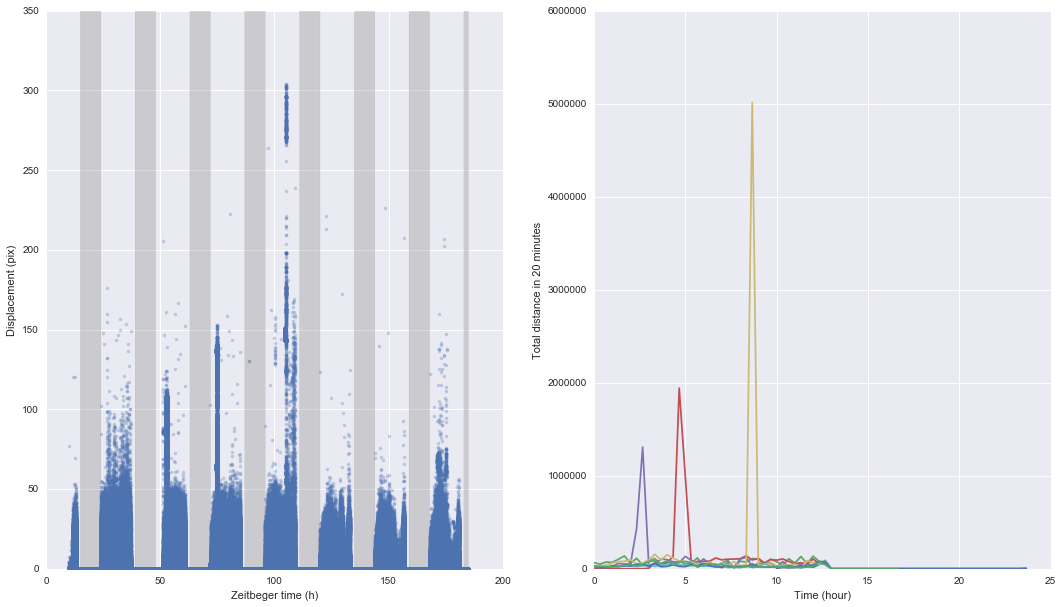

In [29]:
process_animal('Or128', '8/22/2016', ndays=9, save=True, col_names = ['Interval', 'x', 'y', 'Hour', 'Minute', 'Second'])